#SIM Pattern Generator

###The Python version

From the [SI of the paper](http://www.pnas.org/content/suppl/2012/03/15/1119262109.DCSupplemental/pnas.201119262SI.pdf):



In [1]:
%pylab inline
#nice plotting
#import seaborn as sns
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image
import os
import zipfile

Populating the interactive namespace from numpy and matplotlib


In [2]:
def pattern_gen(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    area = vecB.dot(vecN)
    onpix = area*onfrac
    phase_step = vecB/nphases
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB)
    
    xx, yy = meshgrid(arange(sizex),arange(sizey))
    my_grid = dstack((xx,yy))
        
    return mod((my_grid-val).dot(vecN),area) < onpix

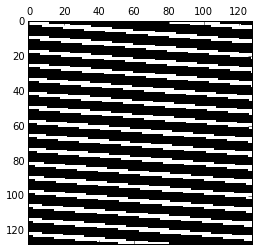

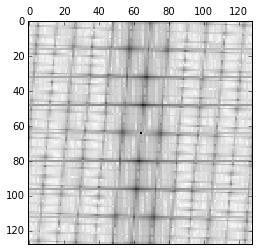

In [60]:
pat =  pattern_gen(array([12, 1]), 8, 0.7, 0, 0, 5, 128, 128)
pat_fft = ifftshift(fftn(fftshift(pat)))
matshow(pat,cmap='Greys')
grid('off')
matshow(log(abs(pat_fft)+0.1),cmap='Greys')
grid('off')

In [4]:
def angles(phi, num_angles, amp):
    thetas = arange(0., num_angles)*pi/1./num_angles + phi
    return np.round(amp*array([cos(thetas), sin(thetas)])).T

In [5]:
@vectorize
def angle_diff(phi, num_angles, amp):
    my_angles = angles(phi,num_angles,amp)
    return mean(abs(pi/num_angles - abs(diff(arctan2(my_angles[:,0],my_angles[:,1])))))

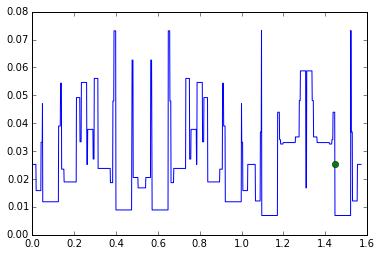

In [57]:
def print_best_angles(num_angles, amp):
    x = linspace(0,pi/2,100*amp)
    my_diffs = angle_diff(x,3,12)
    best_offset = x[argmin(my_diffs)]
    plot(x,my_diffs)
    plot(best_offset, my_diffs[best_offset],'o')
    
print_best_angles(3,12)

In [6]:
def best_angles(num_angles, amp):
    x = linspace(0,2*pi,100*amp)
    my_diffs = angle_diff(x,3,12)
    best_offset = x[argmin(my_diffs)]
    return angles(best_offset, num_angles, amp)

In [7]:
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

In [8]:
def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = pattern_gen(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])
    
    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])))
    
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)/2
    end = region_size+start

    my_pat_fft_subx = my_pat_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]]
    my_pat_fft_suby = my_pat_fft[n/2+peak[0],n/2+peak[1]+start:n/2+peak[1]+end]

    x = arange(start,end)
    
    xfit = polyfit(x, my_pat_fft_subx,2)
    yfit = polyfit(x, my_pat_fft_suby,2)

    x0 = -xfit[1]/(2*xfit[0])
    y0 = -yfit[1]/(2*yfit[0])

    #precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
    precisepeak = peak+[x0,y0]
    #print(precisepeak)
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    #precise_period = n/norm(precisepeak)
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    #print('{:.20f}'.format(precise_period))
    
    return precise_period

In [9]:
#testing different solvers, note that Nelder-Mead and Powell methods are the
#only ones that seem to work for this function.
def objf_l1(period, iperiod, size = 1024):
    angle = array([1,12])
    data = array([pattern_period(angle, period,phaseInd = n,sizex = size) for n in range(1)])
    return mean(abs(data-iperiod))

def objf_l2(*args):
    return objf_l1(*args)**2

%timeit minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

%timeit minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l1_nm = minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l1_p = minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l2_nm = minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l2_p = minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

1 loops, best of 3: 1.64 s per loop
1 loops, best of 3: 2.71 s per loop
1 loops, best of 3: 1.39 s per loop
1 loops, best of 3: 3.66 s per loop


In [10]:
print('x values')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['x'][0],res_l1_p['x']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['x'][0],res_l2_p['x']))
print('Func Calls')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['nfev'],res_l1_p['nfev']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['nfev'],res_l2_p['nfev']))
print('Differences')
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']-res_l1_p['fun']))
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']**2-res_l1_p['fun']**2))
print('L2-norm: Nelder-Mead - Powell = {}'.format(res_l2_nm['fun']-res_l2_p['fun']))

x values
L1-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436047020234469
L2-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436255263697804
Func Calls
L1-norm: Nelder-Mead = 33	Powell = 55
L2-norm: Nelder-Mead = 28	Powell = 73
Differences
L1-norm: Nelder-Mead - Powell = -0.0003552140126465986
L1-norm: Nelder-Mead - Powell = -1.4063966543938126e-07
L2-norm: Nelder-Mead - Powell = -3.68334662853476e-07


It looks like the simplex (`'Nelder-Mead'`) algorithm is the best for this problem. Barring more complex convex methods.

In [24]:
iperiod = ideal_period(568,0.7)

def objf(period, iperiod, size = 1024):
    return objf_l1(period, iperiod, size)/iperiod*100

x = linspace(iperiod-0.05,iperiod+0.05,101)
y512 = array([objf(period, iperiod,512) for period in x])
y1024 = array([objf(period, iperiod,1024) for period in x])
y2048 = array([objf(period, iperiod,2048) for period in x])

In [22]:
res_512 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_1024 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),1024))
res_2048 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),2048))

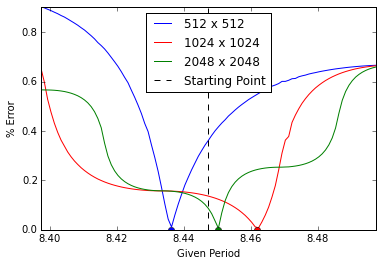

In [25]:
plot(x,y512,'b',label='512 x 512')
plot(res_512['x'],res_512['fun'],'bo')#,label='512 Optimized point')
plot(x,y1024,'r',label='1024 x 1024')
plot(res_1024['x'],res_1024['fun'],'ro')#,label='1024 Optimized point')
plot(x,y2048,'g',label='2048 x 2048')
plot(res_2048['x'],res_2048['fun'],'go')#,label='1024 Optimized point')
axis('tight')
axvline(iperiod,color='k',linestyle='dashed',label='Starting Point')
xlabel('Given Period')
ylabel('% Error')
legend(loc='best')
savefig("PeriodOpt.pdf")

In [9]:
def opt_period(iperiod,angle,**kwargs):
    def objf_l1(period):
        data = array([pattern_period(angle, period, **kwargs) for n in range(1)])
        return mean(abs(data-iperiod))
    
    return minimize(objf_l1, iperiod ,method='Nelder-Mead')['x']

In [16]:
%timeit opt_period(ideal_period(568, 0.85),array([1,12]))

1 loops, best of 3: 28.2 s per loop


In [17]:
my_per = opt_period(ideal_period(568, 0.7),array([1,12]))

In [18]:
pat = pattern_gen([1,12], my_per)

#this is cludgy but seems necessary.
pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')

#write the image
pat_img.convert('1').save('TestPat.bmp')

In [65]:
seq_dir = os.path.join('HHMI_R11_Seq')
seq_files = ['SEQUENCES']
i = 0
for file in os.listdir(seq_dir):
    if '.seq11' in file:
        seq_files.append(chr(65+i)+' "'+file+'"')
        i += 1
        
seq_files.append('SEQUENCES_END')
print("\n".join(seq_files))

SEQUENCES
A "48070 HHMI 10ms.seq11"
B "48071 HHMI 50ms.seq11"
C "48075 HHMI 5ms.seq11"
D "48076 HHMI 20ms.seq11"
E "48077 HHMI 24 50ms.seq11"
F "48078 HHMI 24 1ms.seq11"
G "48083 HHMI 1ms 1-bit Lit Balanced.seq11"
H "48084 HHMI 2ms 1-bit Lit Balanced.seq11"
SEQUENCES_END


In [9]:
with zipfile.ZipFile('Rep568.repz11','r') as my_rep:
    print(my_rep.namelist())
    with my_rep.open('Rep568.rep') as rep:
        print(rep.read().decode())

['Rep568.rep', '48070 HHMI 10ms.seq11', '48071 HHMI 50ms.seq11', '48075 HHMI 5ms.seq11', '48076 HHMI 20ms.seq11', '48077 HHMI 24 50ms.seq11', '48078 HHMI 24 1ms.seq11', '48083 HHMI 1ms 1-bit Lit Balanced.seq11', '48084 HHMI 2ms 1-bit Lit Balanced.seq11', 'pat-6.92003pixel-0.5DC-Ang0Ph0.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph1.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph2.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph3.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph4.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph0.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph1.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph2.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph3.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph4.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph0.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph1.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph2.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph3.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph4.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph0.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph1.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph2.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph3.bmp', 'pat-7.36825pixel-0.5DC

In [61]:
'''
We can use sets as a way to keep track of images and sequences.

Images and sequences will be denoted by strings referring to the actual file name

A repetoire will only contain a list of RunningOrders and have a method to write out running orders.

It should also have the ability to read in a .rep file

Need a method to return a given running order, by name
'''

class RunningOrder(object):
    '''
    A class representing a running order for a 4DD SLM
    '''
    
    def __init__(self, name):
        self._name = name
        #we want these properties to be immutable and we don't want duplicates
        self._sequences = set()
        self._bitplanes = set()
        self._RO = []
        
    @property
    def name(self):
        return self._name
    
    @property
    def sequences(self):
        return self._sequences
    
    @property
    def bitplanes(self):
        return self._bitplanes
    
    @property
    def RO(self):
        return self._RO
    
    def addbitplane(self, sequence, bitplane, position = None):
        '''
        A function to add sequence bitplane pairs to a running order
        '''
        self._sequences.add(sequence)
        self._bitplanes.add(bitplane)
            
        seq_bp = {'sequence' : sequence, 'bitplane' : bitplane}
        
        if position is None:
            self._RO.append(seq_bp)
        else:
            self._RO.insert(position, seq_bp)

class Repetoire(object):
    '''
    This object holds a list of Running orders. It has the ability to output .rep files
    
    Further functionality will be to read in .rep files.
    '''
    
    def __init__(self, listofROs = None):
        self._ROs = []
        self._sequences = set()
        self._bitplanes = set()
        if listofROs is not None:
            for RO in listofROs:
                self.add_RO(RO)
        
    def add_RO(self, RO):
        
        if isinstance(RO, list):
            self.add_RO(RO.pop())
        
        if not isinstance(RO, RunningOrder):
            raise TypeError('Not a RunningOrder')
        else:
            self._ROs.append(RO)
            self._sequences |= RO.sequences
            self._bitplanes |= RO.bitplanes

    def __str__(self):
        '''
        This function writes the repetoire
        '''
        
        toreturn = ''
        
        #If ROs is empty
        if not len(self._ROs):
            return toreturn
        
        ####################
        # MAKING SEQUENCES #
        ####################
        
        #need to save the letter assignments
        seq_dict = {}
        
        seqs = ['SEQUENCES']
        for i, seq in enumerate(sorted(self._sequences)):
            char = chr(65+i)
            seqs.append(char+' "'+seq+'"')
            seq_dict[seq] = char
        
        seqs.append('SEQUENCES_END\n\n')
        
        toreturn = "\n".join(seqs)
        
        ####################
        # MAKING BITPLANES #
        ####################
        
        bp_dict = {}
        bps = ['IMAGES']
        for i, bp in enumerate(sorted(self._bitplanes)):
            bps.append('1 "'+bp+'"')
            bp_dict[bp] = i
        
        bps.append('IMAGES_END\n\n')
        
        toreturn += "\n".join(bps)
        
        #Need to have at least one RunningOrder be Default, why not the first one?
        #If no DEFAULT then MetroCon will continue to look for one and fail.
        toreturn += 'DEFAULT '
        #sort the RunningOrders by name
        for RO in self._ROs:#.sort(key=lambda x: x.name):
            toreturn += self._writeRO(RO, seq_dict, bp_dict)
            
        return toreturn
        
    @staticmethod
    def _writeRO(RO, seq_dict, bp_dict):
        '''
        This function will write the repetoire based on the sequence dict and image dict
        
        It assumes that all that is wanted is standard SIM sequences
        '''
        
        toreturn = ['"{}"'.format(RO.name)]
        
        toreturn.append('[HWA\n')
        
        for seq_bp in RO.RO:
            seq = seq_bp['sequence']
            bp = seq_bp['bitplane']
            toreturn.append(' <t({0},{1}) >\n {{f ({0},{1}) }}'.format(seq_dict[seq],bp_dict[bp]))
            
        toreturn.append(']\n\n')
        
        return '\n'.join(toreturn)
        

In [62]:
my_seqs = ['test_seq{}.seq11'.format(i) for i in range(5)]
my_bps = ['test_bp{}.bmp'.format(i) for i in range(5)]

ROlist = []

for seq in my_seqs:
    my_RO = RunningOrder('My Running Order for {}'.format(seq))
    for bp in my_bps:
        my_RO.addbitplane(seq,bp)
    ROlist.append(my_RO)
    
my_Rep = Repetoire(ROlist)

In [63]:
print(my_Rep)

SEQUENCES
A "test_seq0.seq11"
B "test_seq1.seq11"
C "test_seq2.seq11"
D "test_seq3.seq11"
E "test_seq4.seq11"
SEQUENCES_END

IMAGES
1 "test_bp0.bmp"
1 "test_bp1.bmp"
1 "test_bp2.bmp"
1 "test_bp3.bmp"
1 "test_bp4.bmp"
IMAGES_END

DEFAULT "My Running Order for test_seq0.seq11"
[HWA

 <t(A,0) >
 {f (A,0) }
 <t(A,1) >
 {f (A,1) }
 <t(A,2) >
 {f (A,2) }
 <t(A,3) >
 {f (A,3) }
 <t(A,4) >
 {f (A,4) }
]

"My Running Order for test_seq1.seq11"
[HWA

 <t(B,0) >
 {f (B,0) }
 <t(B,1) >
 {f (B,1) }
 <t(B,2) >
 {f (B,2) }
 <t(B,3) >
 {f (B,3) }
 <t(B,4) >
 {f (B,4) }
]

"My Running Order for test_seq2.seq11"
[HWA

 <t(C,0) >
 {f (C,0) }
 <t(C,1) >
 {f (C,1) }
 <t(C,2) >
 {f (C,2) }
 <t(C,3) >
 {f (C,3) }
 <t(C,4) >
 {f (C,4) }
]

"My Running Order for test_seq3.seq11"
[HWA

 <t(D,0) >
 {f (D,0) }
 <t(D,1) >
 {f (D,1) }
 <t(D,2) >
 {f (D,2) }
 <t(D,3) >
 {f (D,3) }
 <t(D,4) >
 {f (D,4) }
]

"My Running Order for test_seq4.seq11"
[HWA

 <t(E,0) >
 {f (E,0) }
 <t(E,1) >
 {f (E,1) }
 <t(E,2) >
 {f (E,2)

In [104]:
with open('test.txt','w') as test:
    test.write(str(my_Rep))

In [30]:
for x in linspace(0.78,0.85,8):
    print(x)

0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85


In [51]:
best_angles(5,12)

array([[  1.,  12.],
       [ -6.,  11.],
       [-11.,   5.],
       [-12.,  -2.],
       [ -8.,  -9.]])

In [68]:
onfrac = 0.5
my_angles = best_angles(3,12)
    
num_phases = 42

#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('SuperSIM568.repz11', 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = True

    my_dir = os.path.join('568 nm Super SIM','')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NAs = linspace(0.78,0.85,8)
    
    ROlist = []
   
    for bp in my_bps:
        my_RO.addbitplane(seq,bp)
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for NA in NAs:
        print('NA {}'.format(NA))
        
        iperiod = ideal_period(568,NA=NA)
        my_RO = RunningOrder('NA {}'.format(NA))
        
        RO_all = RunningOrder('NA {} All Orientations'.format(NA))

        for angle in my_angles:
            
            #calculate degree from angle for filename
            degree = arctan2(angle[0],angle[1])*180/pi
            
            RO1orient = RunningOrder('NA {} {:+.2f} degrees'.format(NA, degree))
            
            #optimize the angle
            if opt:
                print('Optimizing angle = {:+.2f} degrees'.format(degree))
                my_per = opt_period(iperiod,angle)
            else:
                my_per = iperiod

            for phase in range(num_phases):
                #generate pattern
                pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases)
                
                #make image object
                pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')
                
                #generate filename, put orientation in front, so that its consistent
                name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per[0],onfrac)
                
                #convert to binary and save
                pat_img.convert('1').save(os.path.join(my_dir,name))
                
                #move to zip file and save
                myzip.write(os.path.join(my_dir,name),arcname=name)
                
                my_RO.addbitplane(seq,name)
                
                if not phase:
                    RO1orient.addbitplane(seq,name)
                    RO_all.addbitplane(seq,name)
                
                print('Wrote file: {}'.format(name))
            ROlist.append(RO1orient)
                
        ROlist.append(my_RO)
        ROlist.append(RO_all)
                
    my_Rep = Repetoire(ROlist)
    
    #write the rep file
    with open(os.path.join(my_dir,'SuperSIM568.rep'),'w') as repfile:
        repfile.write(str(my_Rep))
        
    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'SuperSIM568.rep'),arcname='SuperSIM568.rep')
    
print(my_Rep)

Making 568 nm Super SIM\
NA 0.78
Optimizing angle = +4.76 degrees
Wrote file: pat-0.78NA+4.8deg-00ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-01ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-02ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-03ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-04ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-05ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-06ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-07ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-08ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-09ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-10ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-11ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-12ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-13ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-14ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-15ph-7.5683pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-16ph-7.5